In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

batch_size = 128
NUM_WORKERS = int(os.cpu_count() / 2)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=NUM_WORKERS)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=NUM_WORKERS)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
batch_size = 64
NUM_WORKERS = int(os.cpu_count() / 2)


transform = transforms.Compose(
    [
   transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
    ]
)

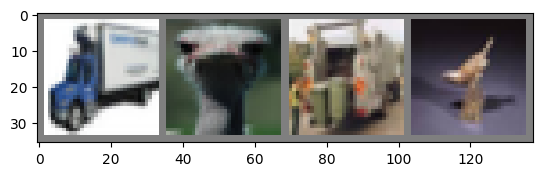

truck bird  truck bird 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
import torchvision
from torch import nn
import torch.nn.functional as F
from torchmetrics import Accuracy

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
import lightning as L
from torchmetrics import Accuracy
import timm

class MyLitModel(L.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model("resnet18", pretrained=True, num_classes=NUM_CLASSES)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr, momentum=0.9)
        return optimizer

In [25]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

model = MyLitModel(lr=0.001)

trainer = L.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
		callbacks=EarlyStopping('val_loss', patience=7),
)

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | loss_fn        | CrossEntropyLoss   | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 391/391 [00:07<00:00, 53.79it/s, v_num=4, train_loss=0.604, train_accuracy=0.812, val_loss=0.863, val_accuracy=0.705]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 391/391 [00:07<00:00, 52.40it/s, v_num=4, train_loss=0.604, train_accuracy=0.812, val_loss=0.863, val_accuracy=0.705]


In [26]:
### Implement test time augmentation to improve the model's performance which generates multiple images from single test image and average the result

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy


def test_time_augmentation(model, test_dataloader, num_augmentations=5):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, _ in test_dataloader:
            augmented_images = []
            
            for _ in range(num_augmentations):
                augmented_images.append(transform(images))
            
            augmented_images = torch.stack(augmented_images)
            outputs = model(augmented_images)
            avg_outputs = torch.mean(outputs, dim=0)
            _, predicted = torch.max(avg_outputs, 1)
            predictions.append(predicted.item())
    
    return predictions

test_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
predictions = test_time_augmentation(model, test_dataloader, num_augmentations=5)
print(predictions)


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>